# Project2_4

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import math
import time
import datetime
import numpy as np
import itertools
import seaborn as sns
from scipy import stats
from colorama import Fore, Style

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
crypto_data_folder = './g-research-crypto-forecasting/'
crypto_data = pd.read_csv(crypto_data_folder + 'train.csv')
asset_data = pd.read_csv(crypto_data_folder + 'asset_details.csv')

In [3]:
def get_initial_asset(asset_id, data=crypto_data):
    df = data[data['Asset_ID'] == asset_id].reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

In [4]:
def prep_train_data(data, asset_id):
    train_df = pd.DataFrame(index=data.index)
    for i in range(16):
        train_df['Close(t-' + str(i) + ')/Close(t)'] = data.Close.shift(i) / data.Close
        train_df['(Close(t-' + str(i) + ')-Open(t-' + str(i) + '))/Close(t)'] = (data.Close.shift(i) - data.Open.shift(
            i)) / data.Close
        train_df['(High(t-' + str(i) + ')-Low(t-' + str(i) + '))/Close(t)'] = (data.High.shift(i) - data.Low.shift(
            i)) / data.Close
        train_df['Volume(t-' + str(i) + ')/Volume(t)'] = data.Volume.shift(i) / data.Volume
        train_df['VWAP(t-' + str(i) + ')/VWAP(t)'] = data.VWAP.shift(i) / data.VWAP
        train_df['VWAP(t-' + str(i) + ')/Close(t)'] = data.VWAP.shift(i) / data.Close
    train_df['Target1'] = data.Target
    train_df['Target2'] = np.log(data.Close.shift(-15) / data.Close)
    w = ['1H', '3H', '6H', '9H', '12H', '24H']
    for i in w:
        train_df['mean(VWAP(' + i + '))/Close(t)'] = data.VWAP.rolling(i).mean() / data.Close
        train_df['mean(Count(' + i + '))/Count(t)'] = data.Count.rolling(i).mean() / data.Count
        train_df['mean(Volume(' + i + '))/Volume(t)'] = data.Volume.rolling(i).mean() / data.Volume
        train_df['min(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).min() / data.Close
        train_df['max(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).max() / data.Close
        train_df['std(VWAP(' + i + '))/Close(t)'] = data.VWAP.rolling(i).std() / data.Close
        train_df['std(Count(' + i + '))/Count(t)'] = data.Count.rolling(i).std() / data.Count
        train_df['std(Volume(' + i + '))/Volume(t)'] = data.Volume.rolling(i).std() / data.Volume
        train_df['std(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).std() / data.Close
    w1 = ['15min', '30min', '1H', '3H']
    for i in w1:
        train_df['mean(VWAP(' + i + '))/mean(VWAP(24H))'] = data.VWAP.rolling(i).mean() / data.VWAP.rolling(
            '24H').mean()
        train_df['mean(Count(' + i + '))/mean(Count(24H))'] = data.Count.rolling(i).mean() / data.Count.rolling(
            '24H').mean()
        train_df['mean(Volume(' + i + '))/mean(Volume(24H))'] = data.Volume.rolling(i).mean() / data.Volume.rolling(
            '24H').mean()
        train_df['mean(High(' + i + '))/mean(High(24H))'] = data.High.rolling(i).mean() / data.High.rolling(
            '24H').mean()
        train_df['mean(Low(' + i + '))/mean(Low(24H))'] = data.Low.rolling(i).mean() / data.Low.rolling('24H').mean()
        train_df['mean(Close(' + i + '))/mean(Close(24H))'] = data.Close.rolling(i).mean() / data.Close.rolling(
            '24H').mean()
        train_df['mean(Low(' + i + '))/mean(VWAP(24H))'] = data.Low.rolling(i).mean() / data.VWAP.rolling('24H').mean()
        train_df['mean(High(' + i + '))/mean(VWAP(24H))'] = data.High.rolling(i).mean() / data.VWAP.rolling(
            '24H').mean()
        train_df['mean(Close(' + i + '))/mean(VWAP(24H))'] = data.Close.rolling(i).mean() / data.VWAP.rolling(
            '24H').mean()
        train_df['std(VWAP(' + i + '))/mean(VWAP(24H))'] = data.VWAP.rolling(i).std() / data.VWAP.rolling('24H').mean()
        train_df['std(Close(' + i + '))/mean(VWAP(24H))'] = data.Close.rolling(i).std() / data.VWAP.rolling(
            '24H').mean()
        train_df['std(Count(' + i + '))/mean(Count(24H))'] = data.Count.rolling(i).std() / data.Count.rolling(
            '24H').mean()
        train_df['std(Volume(' + i + '))/mean(Volume(24H))'] = data.Volume.rolling(i).std() / data.Volume.rolling(
            '24H').mean()
    train_df['date'] = data.index
    train_df['day_of_week'] = train_df['date'].apply(datetime.datetime.weekday)
    train_df['day_of_week'] += 1
    train_df = train_df.drop(columns=['date'])
    train_df['hour'] = data.index.hour
    train_df['minute'] = data.index.minute
    return train_df

In [5]:
bitcoin_raw = get_initial_asset(asset_id=1)
bitcoin = prep_train_data(bitcoin_raw, asset_id=1)

data_raw = bitcoin_raw
data = bitcoin

C:\Users\Crews\AppData\Local\Temp/ipykernel_16968/683031353.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['mean(Volume(' + i + '))/Volume(t)'] = data.Volume.rolling(i).mean() / data.Volume
C:\Users\Crews\AppData\Local\Temp/ipykernel_16968/683031353.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['min(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).min() / data.Close
C:\Users\Crews\AppData\Local\Temp/ipykernel_16968/683031353.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [6]:
features_to_drop=['Close(t-0)/Close(t)', 'VWAP(t-0)/VWAP(t)', 'Volume(t-0)/Volume(t)']

In [7]:
data_1 = data.tail(10016)
data_1.drop(data_1.tail(16).index, inplace=True)
print('Any null data: ', data_1.isna().values.any())
Y1 = pd.DataFrame(data_1.Target1, index=data_1.index)
Y2 = pd.DataFrame(data_1.Target2, index=data_1.index)
X1 = data_1.drop(['Target1', 'Target2'], axis=1)
X1 = X1.drop(features_to_drop, axis=1)

Any null data:  False


C:\Users\Crews\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
data_2 = data.tail(20016)
data_2.drop(data_2.tail(10016).index, inplace=True)
print('Any null data: ', data_2.isna().values.any())
Y12 = pd.DataFrame(data_2.Target1, index=data_2.index)
Y22 = pd.DataFrame(data_2.Target2, index=data_2.index)
X2 = data_2.drop(['Target1', 'Target2'], axis=1)
X2 = X2.drop(features_to_drop, axis=1)

Any null data:  False


C:\Users\Crews\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
data_3 = data.tail(30016)
data_3.drop(data_3.tail(20016).index, inplace=True)
print('Any null data: ', data_3.isna().values.any())
Y13 = pd.DataFrame(data_3.Target1, index=data_3.index)
Y23 = pd.DataFrame(data_3.Target2, index=data_3.index)
X3 = data_3.drop(['Target1', 'Target2'], axis=1)
X3 = X3.drop(features_to_drop, axis=1)

Any null data:  False


C:\Users\Crews\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
data_4 = data.tail(40016)
data_4.drop(data_4.tail(30016).index, inplace=True)
print('Any null data: ', data_4.isna().values.any())
Y14 = pd.DataFrame(data_4.Target1, index=data_4.index)
Y24 = pd.DataFrame(data_4.Target2, index=data_4.index)
X4 = data_4.drop(['Target1', 'Target2'], axis=1)
X4 = X4.drop(features_to_drop, axis=1)

Any null data:  False


C:\Users\Crews\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


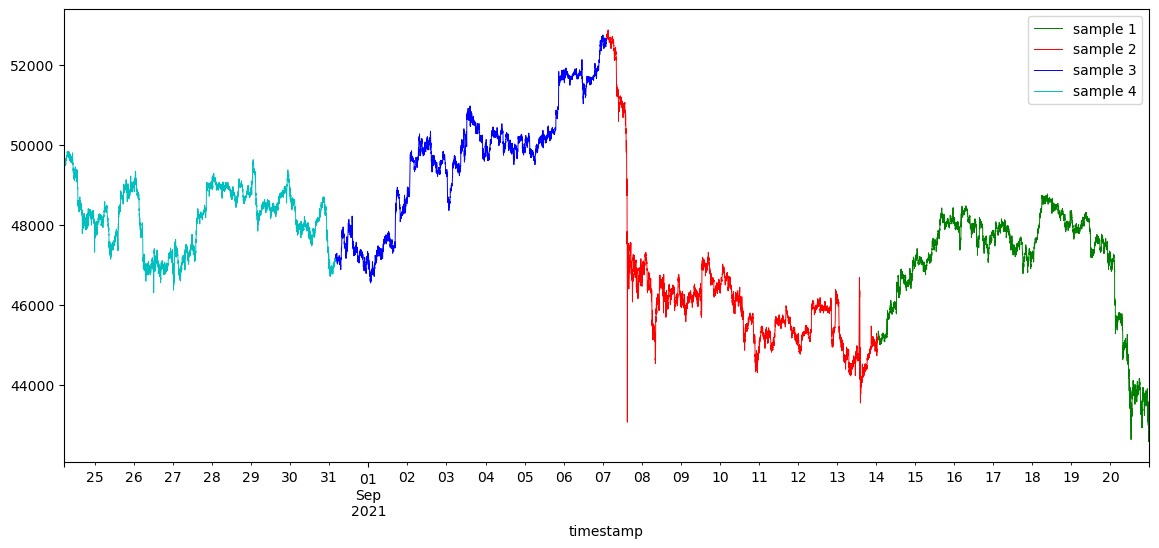

In [11]:
plt.rcParams.update({'figure.figsize':(14,6), 'figure.dpi':100})

data_raw['Close'].loc[X1.index].plot(linewidth=0.7, color='g', label='sample 1')
data_raw['Close'].loc[X2.index].plot(linewidth=0.7, color='r', label='sample 2')
data_raw['Close'].loc[X3.index].plot(linewidth=0.7, color='b', label='sample 3')
data_raw['Close'].loc[X4.index].plot(linewidth=0.7, color='c', label='sample 4')

plt.legend()
plt.show()

In [12]:
X1_train, X1_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X1, Y1, Y2, test_size=0.2, shuffle=False)
print('All data size: %d' % X1.size)
print('Train data size: %d' % X1_train.size)
print('Test data size: %d' % X1_test.size)

All data size: 2020000
Train data size: 1616000
Test data size: 404000


In [13]:
X2_train, X2_test, Y12_train, Y12_test, Y22_train, Y22_test = train_test_split(X2, Y12, Y22, test_size=0.2, shuffle=False)
print('All data size: %d' % X2.size)
print('Train data size: %d' % X2_train.size)
print('Test data size: %d' % X2_test.size)

All data size: 2020000
Train data size: 1616000
Test data size: 404000


In [14]:
X3_train, X3_test, Y13_train, Y13_test, Y23_train, Y23_test = train_test_split(X3, Y13, Y23, test_size=0.2, shuffle=False)
print('All data size: %d' % X3.size)
print('Train data size: %d' % X3_train.size)
print('Test data size: %d' % X3_test.size)

All data size: 2020000
Train data size: 1616000
Test data size: 404000


In [15]:
X4_train, X4_test, Y14_train, Y14_test, Y24_train, Y24_test = train_test_split(X4, Y14, Y24, test_size=0.2, shuffle=False)
print('All data size: %d' % X4.size)
print('Train data size: %d' % X4_train.size)
print('Test data size: %d' % X4_test.size)

All data size: 2020000
Train data size: 1616000
Test data size: 404000


## Regressor and params

In [23]:
reg = xgboost.XGBRegressor()

In [24]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [25]:
eta_set = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
nest_set = [100, 300, 500, 700, 1000, 1300, 1500]
lambda_set = [1, 5, 10, 50, 100]
alpha_set = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

### RandomSearch Y2 BlockingTimeSeriesSplit

In [12]:
params_set = {
    'eta': eta_set,
    'n_estimators': nest_set,
    'lambda': lambda_set,
    'alpha': alpha_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [13]:
start = time.time()
rand_search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=params_set,
    n_iter=100,
    random_state=1,
    cv=BlockingTimeSeriesSplit(n_splits=7).split(X1_train),
    scoring='neg_mean_squared_error'
)
rand_search.fit(X1_train, Y2_train)
tuning_time1 = time.time() - start

In [14]:
print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time1)))

Tuning time:  0:36:21


In [15]:
best_model = rand_search.best_estimator_

In [16]:
best_model.save_model('models/rand2.json')

In [17]:
result_rand = pd.DataFrame(rand_search.cv_results_)
result_rand.to_csv('cv_results/rand2.csv')

In [193]:
result_rand = pd.read_csv('cv_results/rand2.csv')
result_rand['mean_test_score'] = -result_rand.mean_test_score
result_rand

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_n_estimators,param_lambda,param_eval_metric,param_eta,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,3.534668,0.245629,0.013884,0.016867,reg:pseudohubererror,700,50,rmse,0.030,...,-0.000036,-0.000006,-0.000008,-0.000033,-0.000007,-0.000009,-0.000064,0.000023,0.000020,51
1,1,1.883714,0.058295,0.008428,0.000728,reg:pseudohubererror,700,5,rmse,0.003,...,-0.003138,-0.003015,-0.003139,-0.003064,-0.003033,-0.003156,-0.003161,0.003101,0.000057,80
2,2,3.880855,0.291113,0.007573,0.000495,reg:pseudohubererror,700,50,rmse,0.010,...,-0.000038,-0.000005,-0.000010,-0.000035,-0.000007,-0.000010,-0.000050,0.000022,0.000017,39
3,3,2.992285,0.144427,0.006858,0.000350,reg:pseudohubererror,1000,10,rmse,0.300,...,-0.000038,-0.000008,-0.000008,-0.000017,-0.000012,-0.000011,-0.000054,0.000021,0.000017,22
4,4,7.544310,0.464937,0.008404,0.000716,reg:pseudohubererror,1300,1,rmse,0.010,...,-0.000029,-0.000008,-0.000008,-0.000006,-0.000010,-0.000005,-0.000017,0.000012,0.000008,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2.347570,0.110744,0.007287,0.000699,reg:pseudohubererror,700,1,rmse,0.100,...,-0.000036,-0.000006,-0.000007,-0.000026,-0.000007,-0.000009,-0.000069,0.000023,0.000022,48
96,96,4.240713,0.044283,0.007001,0.000002,reg:pseudohubererror,1500,1,rmse,0.300,...,-0.000033,-0.000009,-0.000008,-0.000007,-0.000010,-0.000007,-0.000015,0.000013,0.000009,5
97,97,0.303286,0.011876,0.007858,0.000638,reg:pseudohubererror,100,100,rmse,0.030,...,-0.000899,-0.000834,-0.000898,-0.000858,-0.000843,-0.000908,-0.000913,0.000879,0.000030,76
98,98,0.282571,0.002259,0.007857,0.000350,reg:pseudohubererror,100,50,rmse,0.030,...,-0.000668,-0.000612,-0.000666,-0.000633,-0.000620,-0.000675,-0.000680,0.000651,0.000026,71


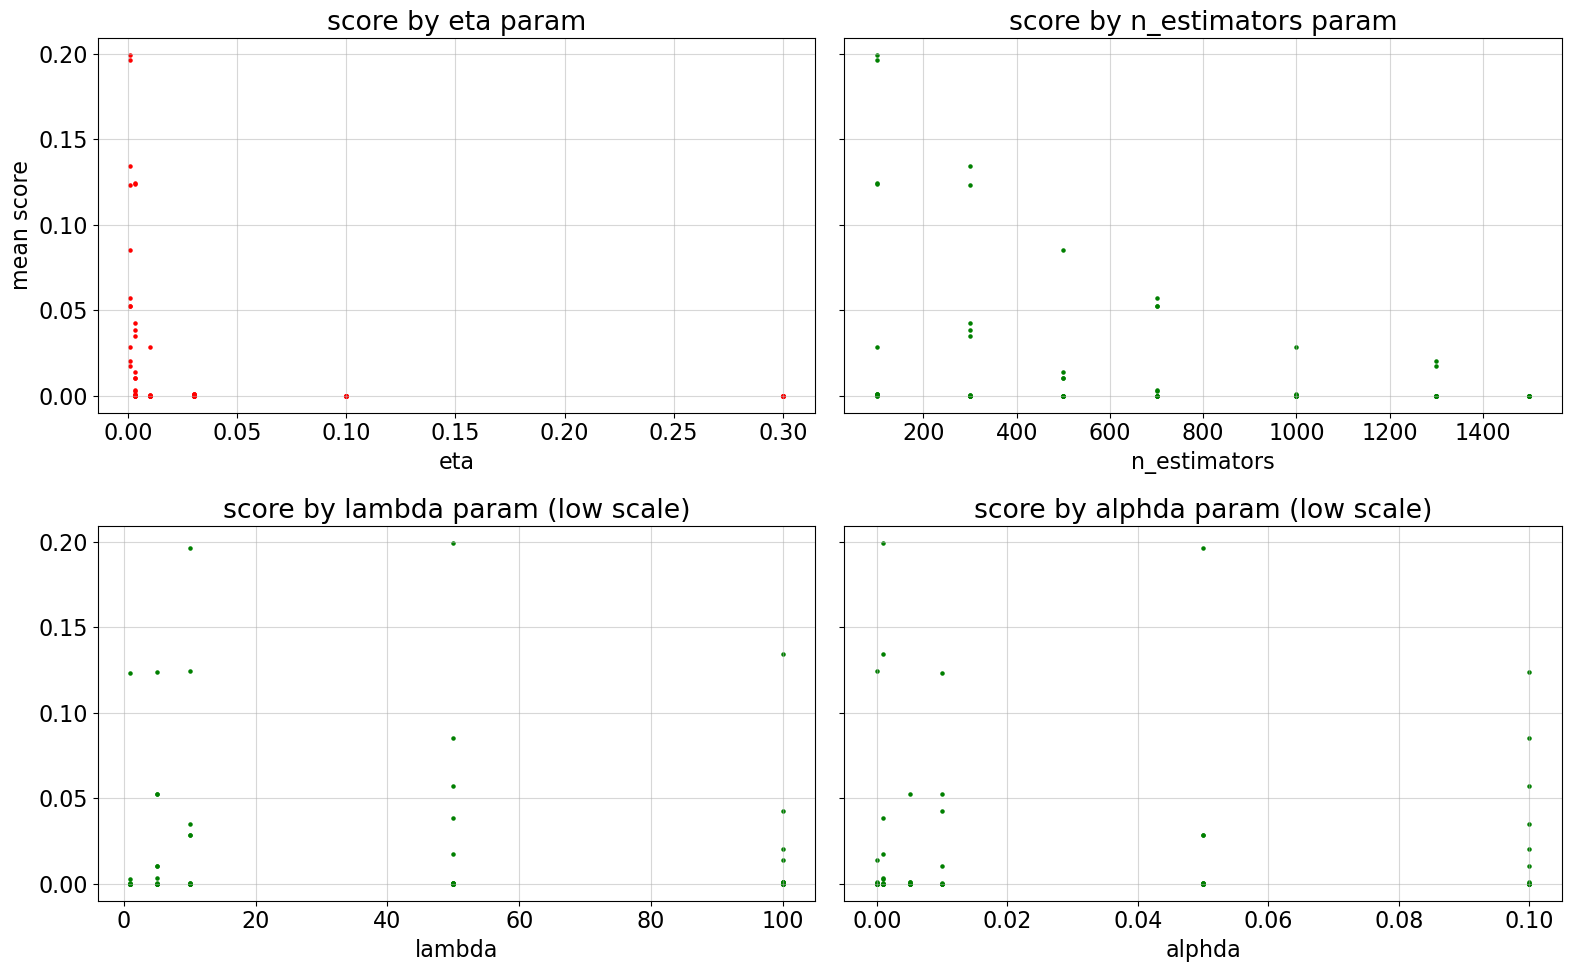

In [200]:
plt.rcParams.update({'figure.figsize':(16,10), 'figure.dpi':100, 'font.size':16})

fig, axes = plt.subplots(2, 2, sharey='row')

axes[0, 0].scatter(result_rand.param_eta, result_rand.mean_test_score, c='red', s=5)
axes[0, 0].set_ylabel('mean score')
axes[0, 0].set_xlabel('eta')
axes[0, 0].grid(which='major', alpha=0.5)
axes[0, 0].grid(which='minor', alpha=0.2)
axes[0, 0].set_title('score by eta param')

axes[0, 1].scatter(result_rand.param_n_estimators, result_rand.mean_test_score, c='green', s=5)
axes[0, 1].set_xlabel('n_estimators')
axes[0, 1].grid(which='major', alpha=0.5)
axes[0, 1].grid(which='minor', alpha=0.2)
axes[0, 1].set_title('score by n_estimators param')

axes[1, 1].scatter(result_rand.param_alpha, result_rand.mean_test_score, c='green', s=5)
axes[1, 1].set_xlabel('alphda')
axes[1, 1].grid(which='major', alpha=0.5)
axes[1, 1].grid(which='minor', alpha=0.2)
axes[1, 1].set_title('score by alphda param (low scale)')

axes[1, 0].scatter(result_rand.param_lambda, result_rand.mean_test_score, c='green', s=5)
axes[1, 0].set_xlabel('lambda')
axes[1, 0].grid(which='major', alpha=0.5)
axes[1, 0].grid(which='minor', alpha=0.2)
axes[1, 0].set_title('score by lambda param (low scale)')

plt.tight_layout()
plt.show()

In [4]:
best_model = xgboost.XGBRegressor()
best_model.load_model('models/rand2.json')

In [5]:
best_params = best_model.get_params()
best_eta = best_params['eta']
best_nest = best_params['n_estimators']
best_lambda=best_params['lambda']
best_alpha=best_params['alpha']

In [21]:
print('Best eta: ', best_eta)
print('Best n_estimators: ', best_nest)
print('Best lambda: ', best_lambda)
print('Best alpha: ', best_alpha)

Best eta:  0.03
Best n_estimators:  700
Best lambda:  1
Best alpha:  0


### Model with best params Y2

In [26]:
model2 = xgboost.XGBRegressor(
    eta=best_eta,
    n_estimators=best_nest,
    reg_lambda=best_lambda,
    alpha=best_alpha,
    eval_metric='rmse',
    booster='gbtree',
    objective='reg:pseudohubererror'
)
model2.fit(X1_train, Y2_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.03, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', ...)

In [27]:
pred_train2 = model2.predict(X1_train)
pred_test2 = model2.predict(X1_test)

pred_train_series2 = pd.Series(pred_train2, index=Y2_train.index)
pred_test_series2 = pd.Series(pred_test2, index=Y2_test.index)

rmse_train2 = math.sqrt(mean_squared_error(Y2_train, pred_train2))
rmse_test2 = math.sqrt(mean_squared_error(Y2_test, pred_test2))

In [28]:
print('train rmse: ', rmse_train2)
print('test rmse: ', rmse_test2)

train rmse:  0.0005391966574853151
test rmse:  0.007294920724862579


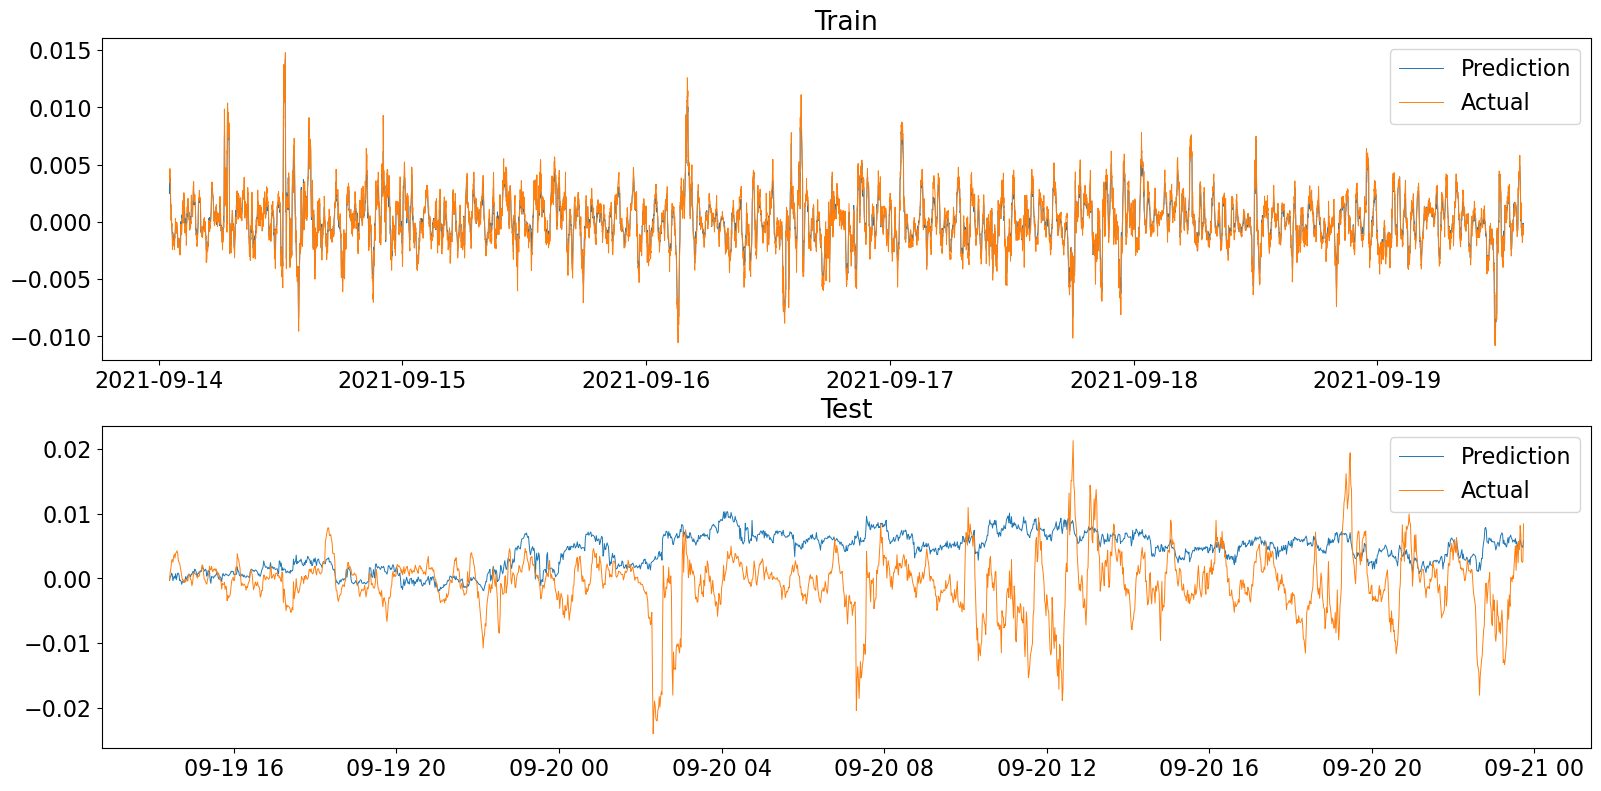

In [29]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100,'lines.linewidth': 0.7, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series2, label='Prediction')
axes[0].plot(Y2_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series2, label='Prediction')
axes[1].plot(Y2_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

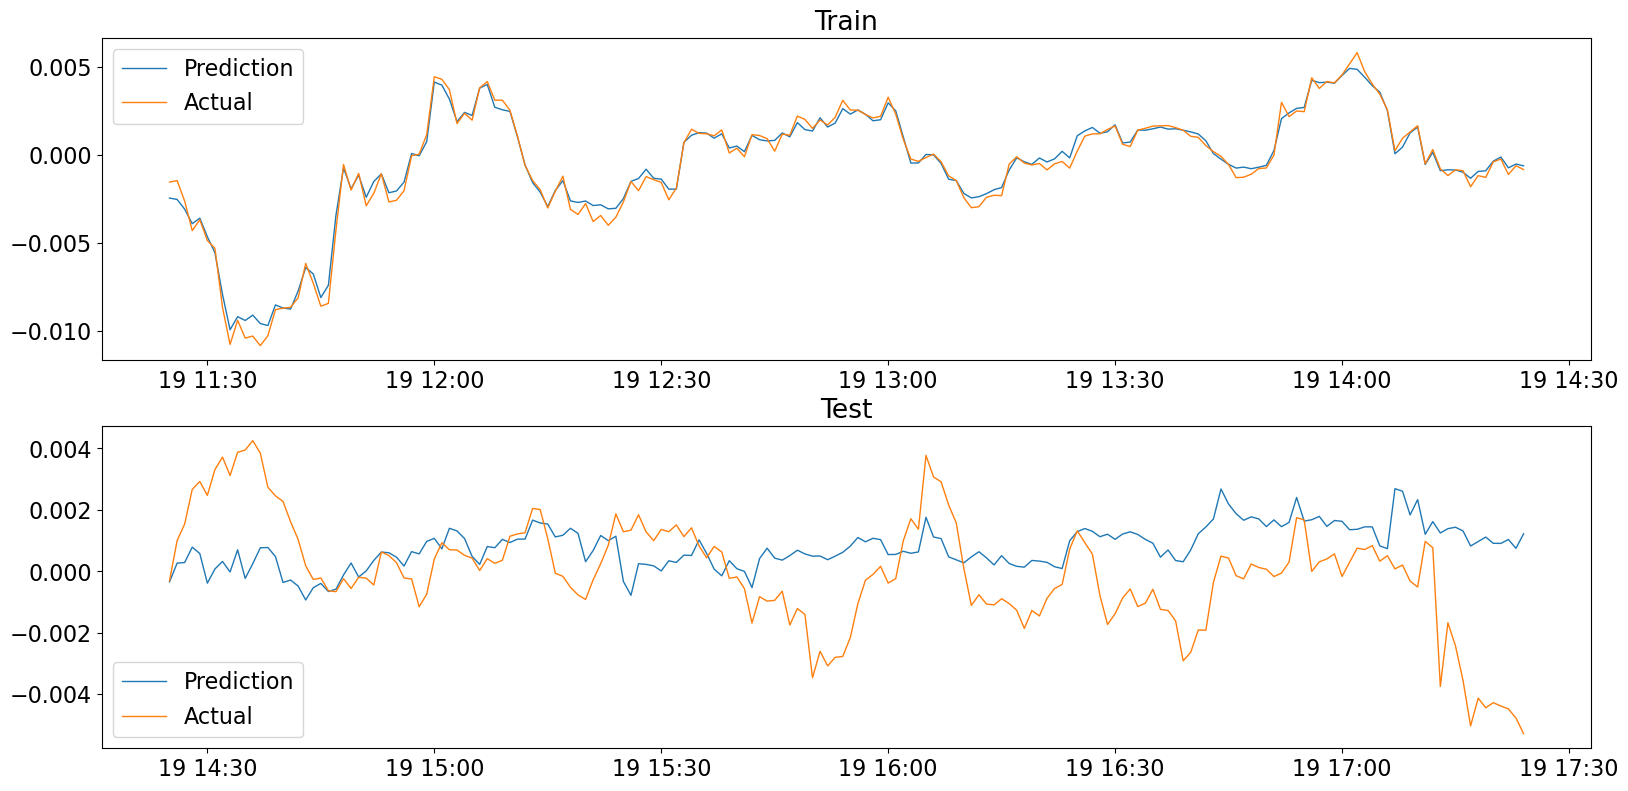

In [32]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100,'lines.linewidth': 1, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series2.tail(180), label='Prediction')
axes[0].plot(Y2_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series2.head(180), label='Prediction')
axes[1].plot(Y2_test.head(180), label='Actual')
axes[1].set_title('Test')
axes[1].legend()

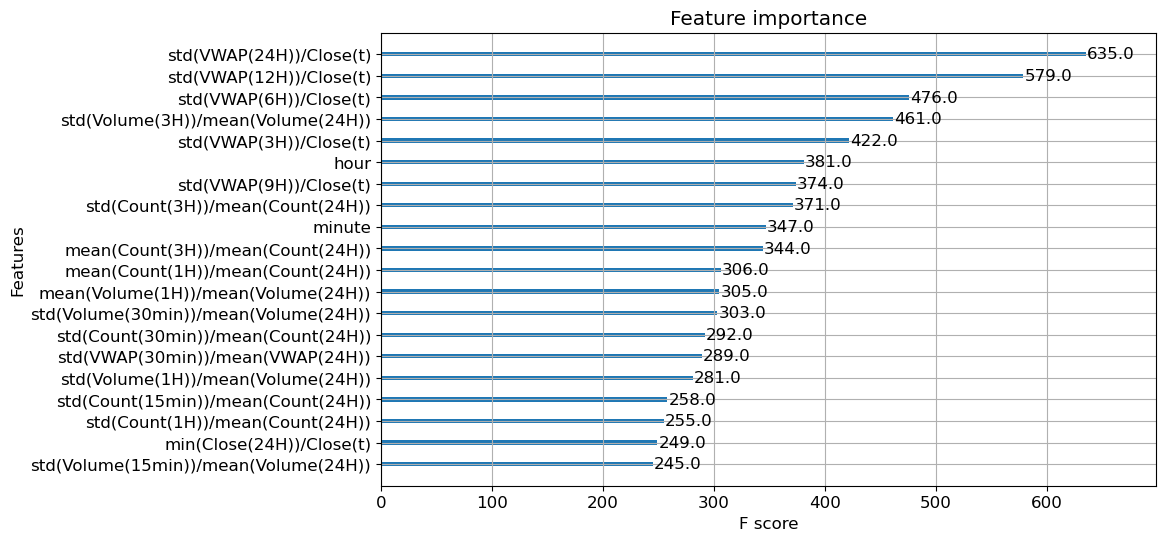

In [34]:
plt.rcParams.update({'figure.dpi': 100, 'font.size':12})

ax = xgboost.plot_importance(model2, max_num_features=20)
fig = ax.figure
fig.set_size_inches(10, 6)

In [161]:
pred_series2 = pd.concat([pred_train_series2, pred_test_series2])
close_series2 = data_raw.Close.loc[data_1.index]
target_series2 = data_1.Target2

In [172]:
table2 = pd.DataFrame({'initial target': target_series2, 'predicted target': pred_series2, 'actual close': close_series2, 'timestamp': data_1.index})

In [173]:
table2['mean(Close(1H))']=data_raw.Close.rolling('1H').mean()
table2['Close(t+15)']=(table2['initial target']+1)*table2['mean(Close(1H))']
table2['predicted Close(t+15)']=(table2['predicted target']+1)*table2['mean(Close(1H))']
table2['Close(t+15)']=table2['Close(t+15)'].shift(-15)
table2['predicted Close(t+15)']=table2['predicted Close(t+15)'].shift(-15)

In [174]:
table2.to_csv('close_predictions/table2.csv')

In [175]:
table2 = pd.read_csv('close_predictions/table2.csv')
table2 = table2.reset_index(drop=True)
table2['timestamp'] = pd.to_datetime(table2['timestamp'])
table2 = table2.set_index('timestamp')
table2

,initial target,predicted target,actual close,timestamp.1,mean(Close(1H)),Close(t+15),predicted Close(t+15)
timestamp,,,,,,,
2021-09-14 01:05:00,0.003454,0.002470,45135.727143,2021-09-14 01:05:00,45067.694199,45058.906894,45057.253724
2021-09-14 01:06:00,0.003740,0.003607,45129.775714,2021-09-14 01:06:00,45069.581771,45055.102915,45056.500838
2021-09-14 01:07:00,0.004640,0.003567,45138.098571,2021-09-14 01:07:00,45072.839461,45004.321533,45039.841833
2021-09-14 01:08:00,0.004477,0.003853,45131.365714,2021-09-14 01:08:00,45077.190914,45029.135130,45036.967698
2021-09-14 01:09:00,0.003381,0.003185,45124.667143,2021-09-14 01:09:00,45080.713643,45079.486252,45084.806751
...,...,...,...,...,...,...,...
2021-09-20 23:40:00,0.006572,0.005552,42703.636250,2021-09-20 23:40:00,43139.958154,NaN,NaN
2021-09-20 23:41:00,0.002732,0.004896,42781.970571,2021-09-20 23:41:00,43121.878747,NaN,NaN
2021-09-20 23:42:00,0.002439,0.004962,42755.592500,2021-09-20 23:42:00,43103.707812,NaN,NaN


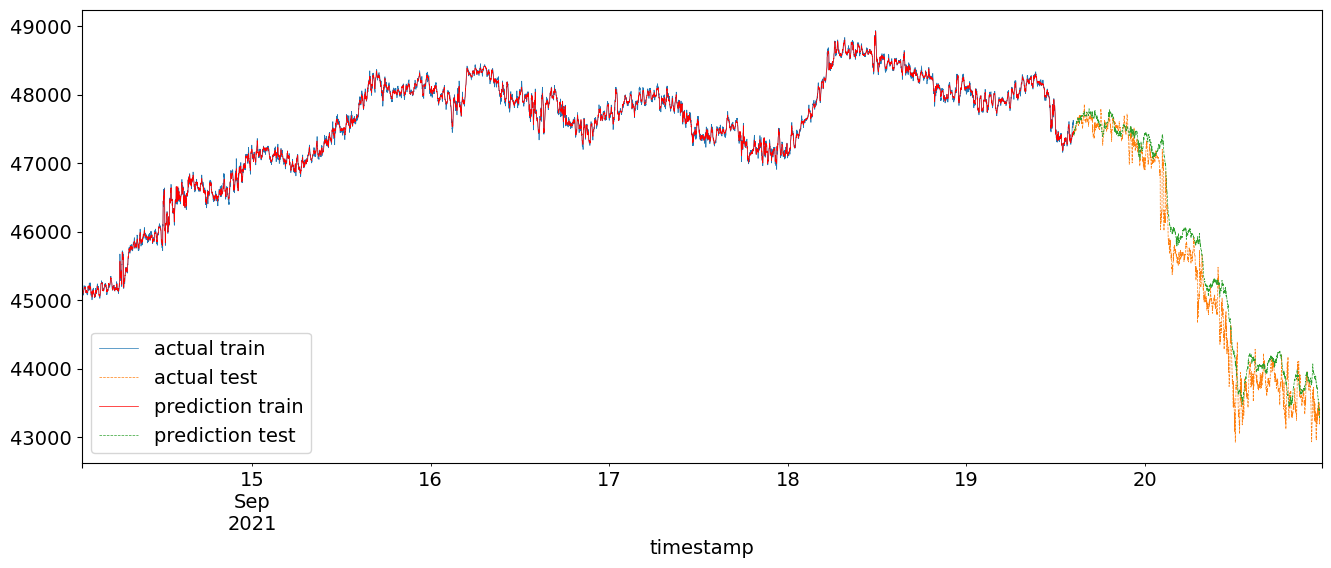

In [200]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 0.5, 'font.size': 14})

table2['Close(t+15)'].loc[Y2_train.index].plot(label='actual train')
table2['Close(t+15)'].loc[Y2_test.index].plot(label='actual test', linestyle='--')
table2['predicted Close(t+15)'].loc[Y2_train.index].plot(label='prediction train', color='r')
table2['predicted Close(t+15)'].loc[Y2_test.index].plot(label='prediction test', linestyle='--')

plt.legend()
plt.show()

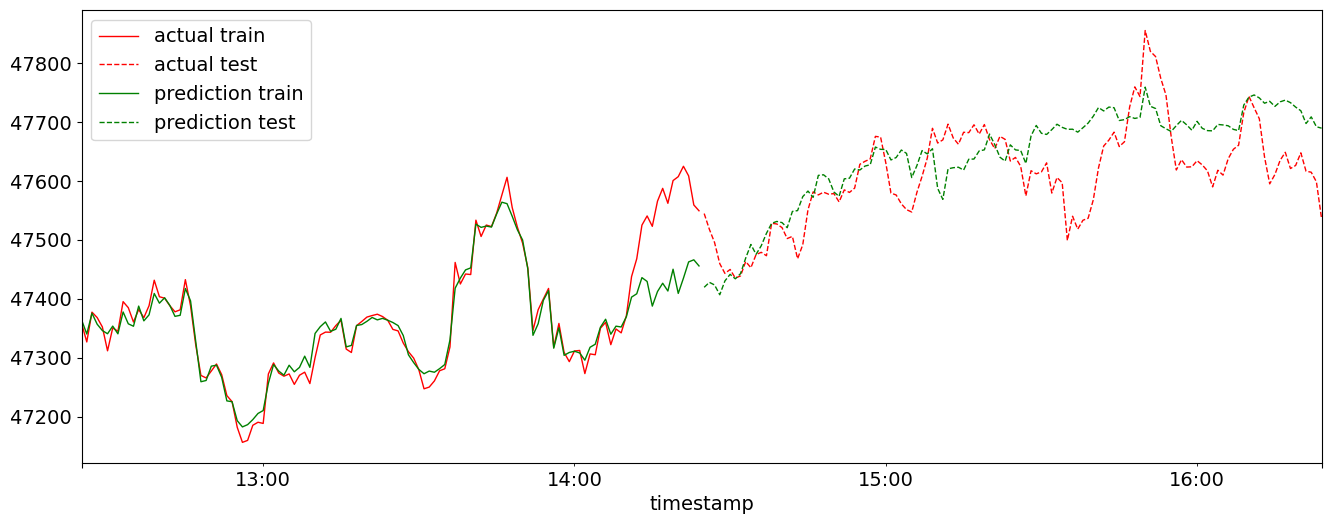

In [177]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 1, 'font.size': 14})

table2['Close(t+15)'].loc[Y2_train.tail(120).index].plot(label='actual train', color='r')
table2['Close(t+15)'].loc[Y2_test.head(120).index].plot(label='actual test', linestyle='--', color='r')
table2['predicted Close(t+15)'].loc[Y2_train.tail(120).index].plot(label='prediction train', color='g')
table2['predicted Close(t+15)'].loc[Y2_test.head(120).index].plot(label='prediction test', linestyle='--', color='g')

plt.legend()
plt.show()

### Model with best params Y22

In [36]:
model22 = xgboost.XGBRegressor(
    eta=best_eta,
    n_estimators=best_nest,
    reg_lambda=best_lambda,
    alpha=best_alpha,
    eval_metric='rmse',
    booster='gbtree',
    objective='reg:pseudohubererror'
)
model22.fit(X2_train, Y22_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.03, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', ...)

In [37]:
pred_train22 = model22.predict(X2_train)
pred_test22 = model22.predict(X2_test)

pred_train_series22 = pd.Series(pred_train22, index=Y22_train.index)
pred_test_series22 = pd.Series(pred_test22, index=Y22_test.index)

rmse_train22 = math.sqrt(mean_squared_error(Y22_train, pred_train22))
rmse_test22 = math.sqrt(mean_squared_error(Y22_test, pred_test22))

In [38]:
print('train rmse: ', rmse_train22)
print('test rmse: ', rmse_test22)

train rmse:  0.0007872648847565624
test rmse:  0.0057184884768310745


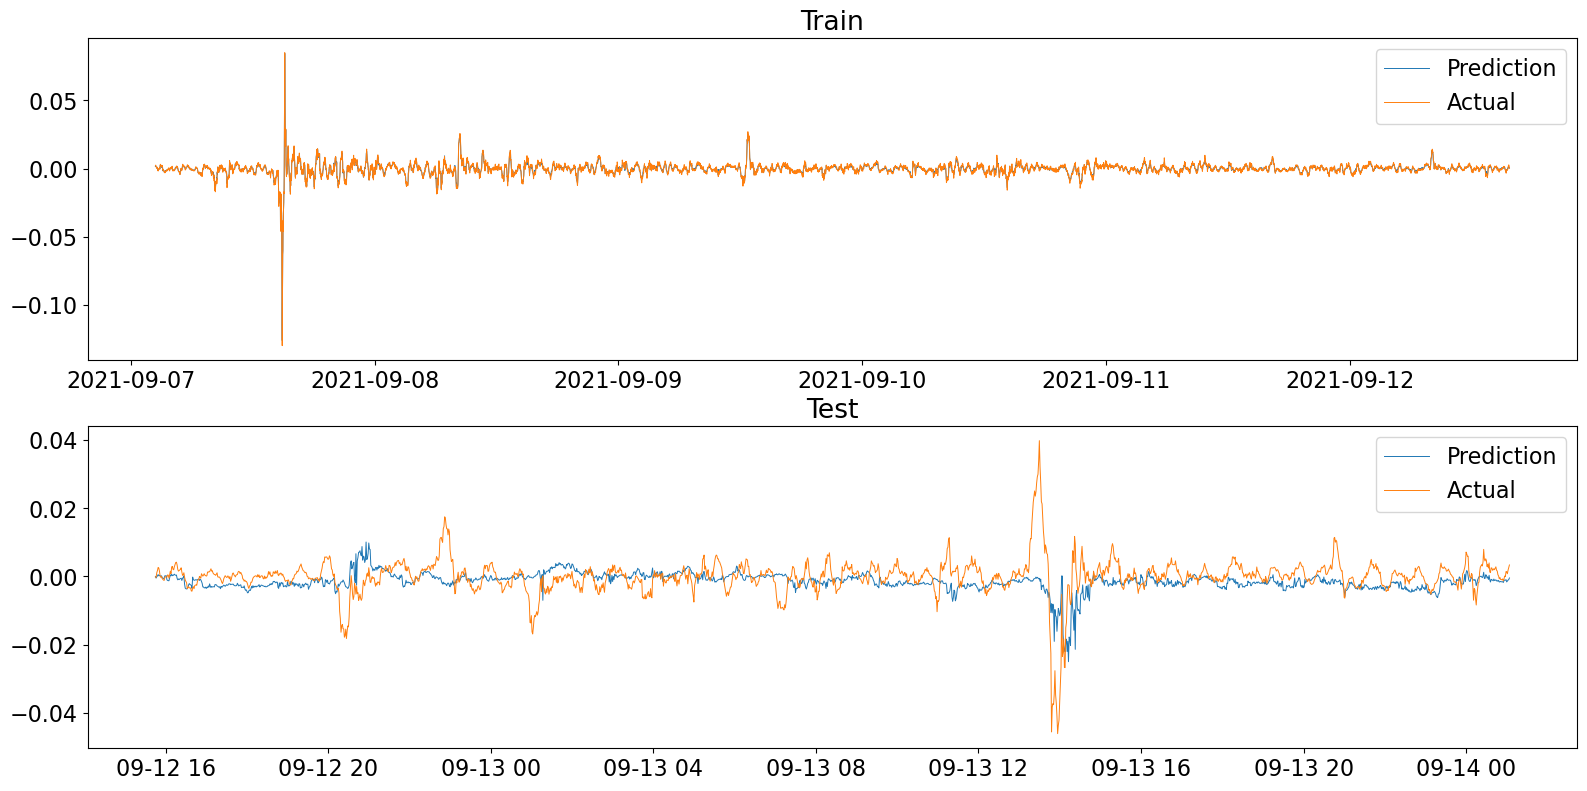

In [39]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'lines.linewidth': 0.7, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series22, label='Prediction')
axes[0].plot(Y22_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series22, label='Prediction')
axes[1].plot(Y22_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

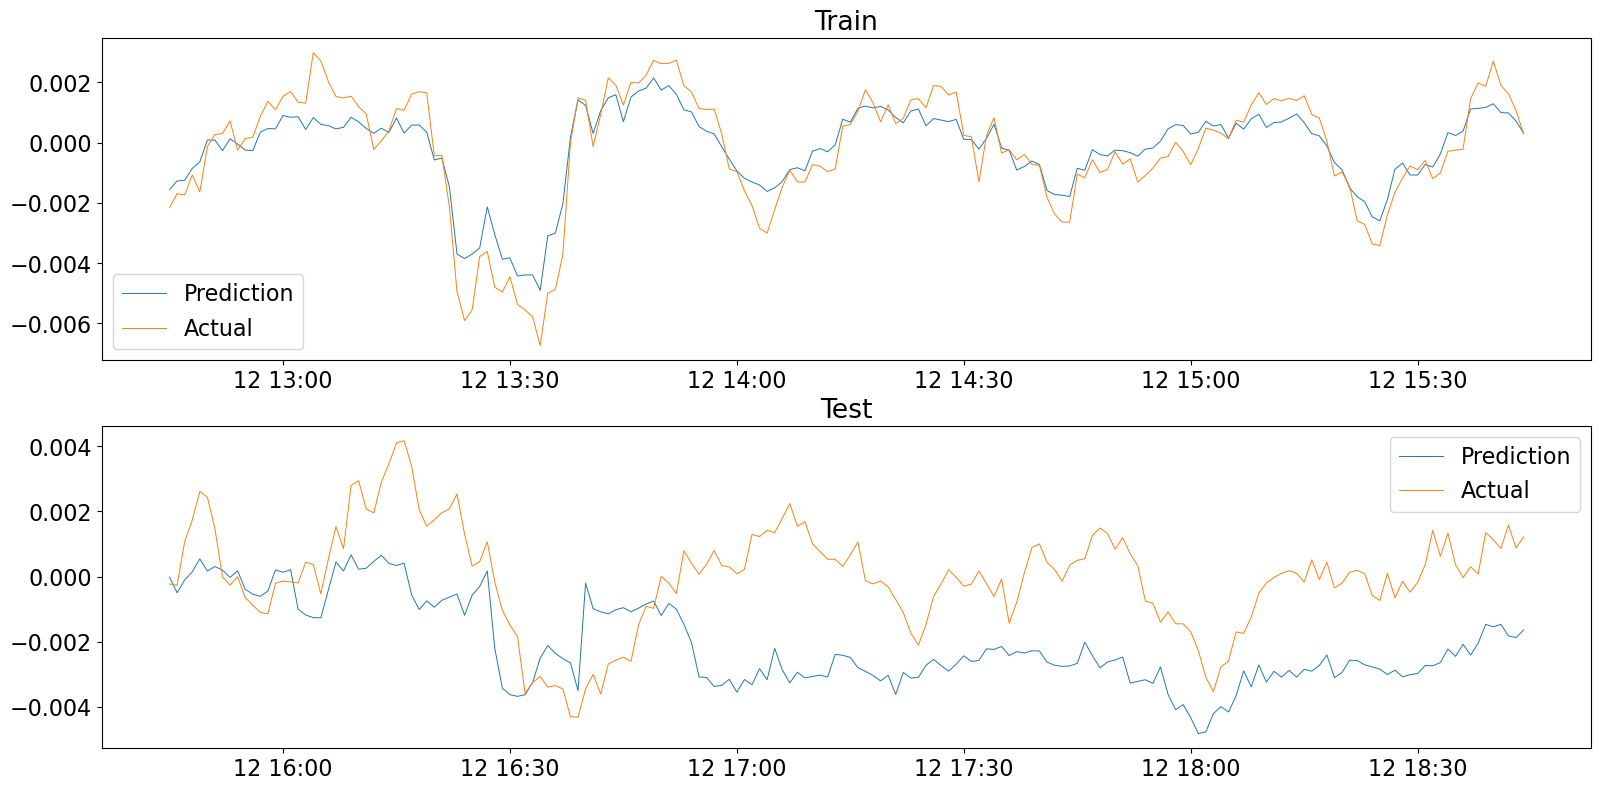

In [40]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series22.tail(180), label='Prediction')
axes[0].plot(Y22_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series22.head(180), label='Prediction')
axes[1].plot(Y22_test.head(180), label='Actual')
axes[1].set_title('Test')
axes[1].legend()

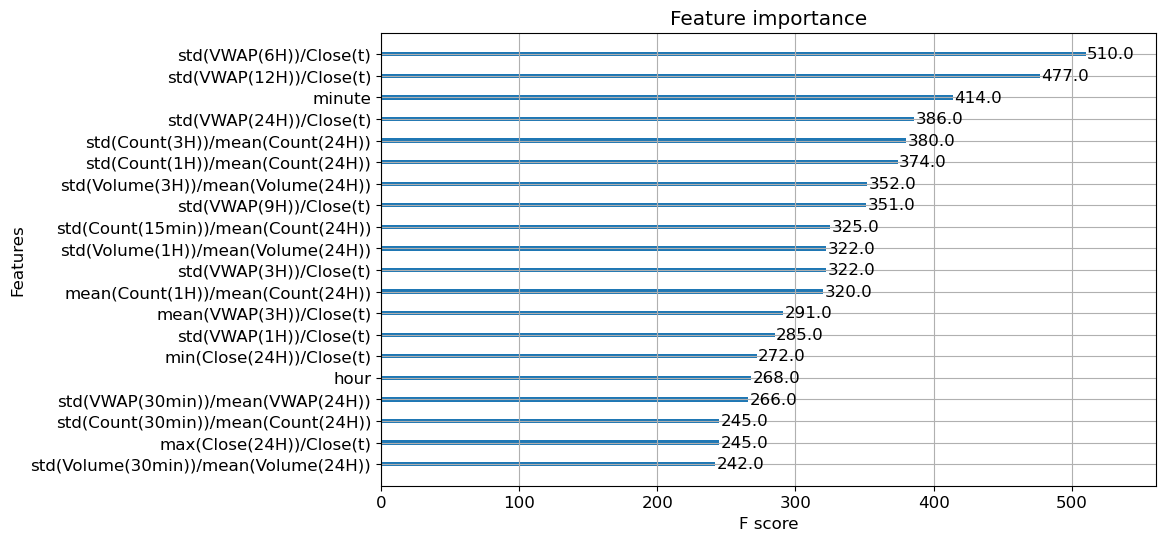

In [41]:
plt.rcParams.update({'figure.dpi': 100, 'font.size':12})

ax = xgboost.plot_importance(model22, max_num_features=20)
fig = ax.figure
fig.set_size_inches(10, 6)

In [96]:
pred_series22 = pd.concat([pred_train_series22, pred_test_series22])
close_series22 = data_raw.Close.loc[data_2.index]
target_series22 = data_2.Target2

In [168]:
table22 = pd.DataFrame({'initial target': target_series22, 'predicted target': pred_series22, 'actual close': close_series22})

NameError: name 'target_series22' is not defined

In [178]:
table22['mean(Close(1H))']=data_raw.Close.rolling('1H').mean()
table22['Close(t+15)']=(table22['initial target']+1)*table22['mean(Close(1H))']
table22['predicted Close(t+15)']=(table22['predicted target']+1)*table22['mean(Close(1H))']
table22['Close(t+15)']=table22['Close(t+15)'].shift(-15)
table22['predicted Close(t+15)']=table22['predicted Close(t+15)'].shift(-15)

In [179]:
table22.to_csv('close_predictions/table22.csv')

In [180]:
table22 = pd.read_csv('close_predictions/table22.csv')
table22 = table22.reset_index(drop=True)
table22['timestamp'] = pd.to_datetime(table22['timestamp'])
table22 = table22.set_index('timestamp')
table22

,initial target,predicted target,actual close,mean(Close(1H)),Close(t+15),predicted Close(t+15)
timestamp,,,,,,
2021-09-07 02:25:00,0.001997,0.001569,52653.021429,52574.771618,52536.146646,52567.684105
2021-09-07 02:26:00,0.002214,0.001634,52652.668571,52575.349427,52516.024247,52566.847687
2021-09-07 02:27:00,0.002519,0.001504,52629.605714,52575.586710,52549.004441,52579.360470
2021-09-07 02:28:00,0.001791,0.001550,52656.347143,52576.427615,52572.647181,52579.387232
2021-09-07 02:29:00,0.001487,0.001311,52667.572857,52577.655122,52580.095907,52598.047201
...,...,...,...,...,...,...
2021-09-14 01:00:00,0.001363,-0.001617,45196.012857,45049.405446,NaN,NaN
2021-09-14 01:01:00,0.000788,-0.001327,45186.212857,45053.598612,NaN,NaN
2021-09-14 01:02:00,0.001854,-0.001073,45170.600000,45058.244008,NaN,NaN


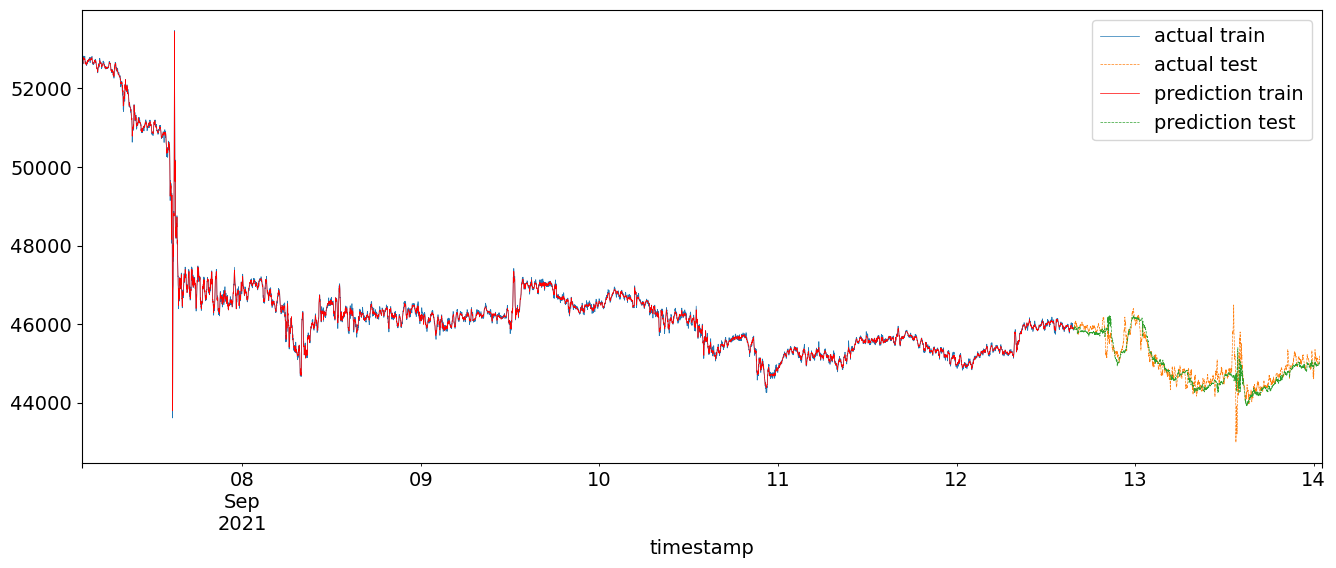

In [201]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 0.5, 'font.size': 14})

table22['Close(t+15)'].loc[Y22_train.index].plot(label='actual train')
table22['Close(t+15)'].loc[Y22_test.index].plot(label='actual test', linestyle='--')
table22['predicted Close(t+15)'].loc[Y22_train.index].plot(label='prediction train', color='r')
table22['predicted Close(t+15)'].loc[Y22_test.index].plot(label='prediction test', linestyle='--')

plt.legend()
plt.show()

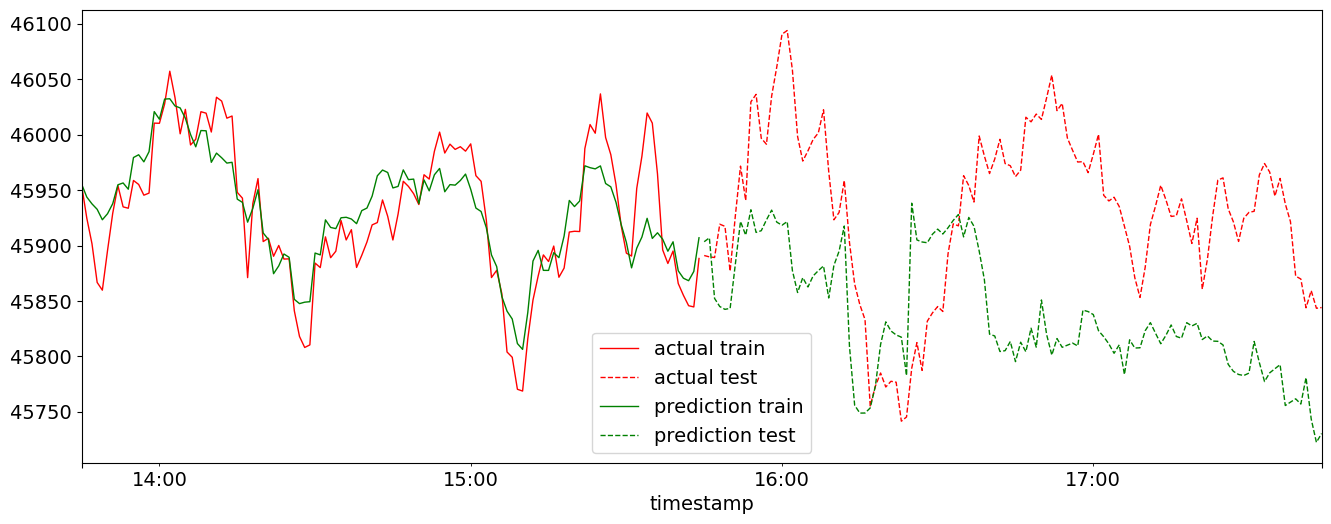

In [188]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 1, 'font.size': 14})

table22['Close(t+15)'].loc[Y22_train.tail(120).index].plot(label='actual train', color='r')
table22['Close(t+15)'].loc[Y22_test.head(120).index].plot(label='actual test', linestyle='--', color='r')
table22['predicted Close(t+15)'].loc[Y22_train.tail(120).index].plot(label='prediction train', color='g')
table22['predicted Close(t+15)'].loc[Y22_test.head(120).index].plot(label='prediction test', linestyle='--', color='g')

plt.legend()
plt.show()

### RandomSearch Y23 BlockingTimeSeriesSplit

In [42]:
model23 = xgboost.XGBRegressor(
    eta=best_eta,
    n_estimators=best_nest,
    reg_lambda=best_lambda,
    alpha=best_alpha,
    eval_metric='rmse',
    booster='gbtree',
    objective='reg:pseudohubererror'
)
model23.fit(X3_train, Y23_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.03, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', ...)

In [43]:
pred_train23 = model23.predict(X3_train)
pred_test23 = model23.predict(X3_test)

pred_train_series23 = pd.Series(pred_train23, index=Y23_train.index)
pred_test_series23 = pd.Series(pred_test23, index=Y23_test.index)

rmse_train23 = math.sqrt(mean_squared_error(Y23_train, pred_train23))
rmse_test23 = math.sqrt(mean_squared_error(Y23_test, pred_test23))

In [44]:
print('train rmse: ', rmse_train23)
print('test rmse: ', rmse_test23)

train rmse:  0.0005946691254432468
test rmse:  0.002849571563819365


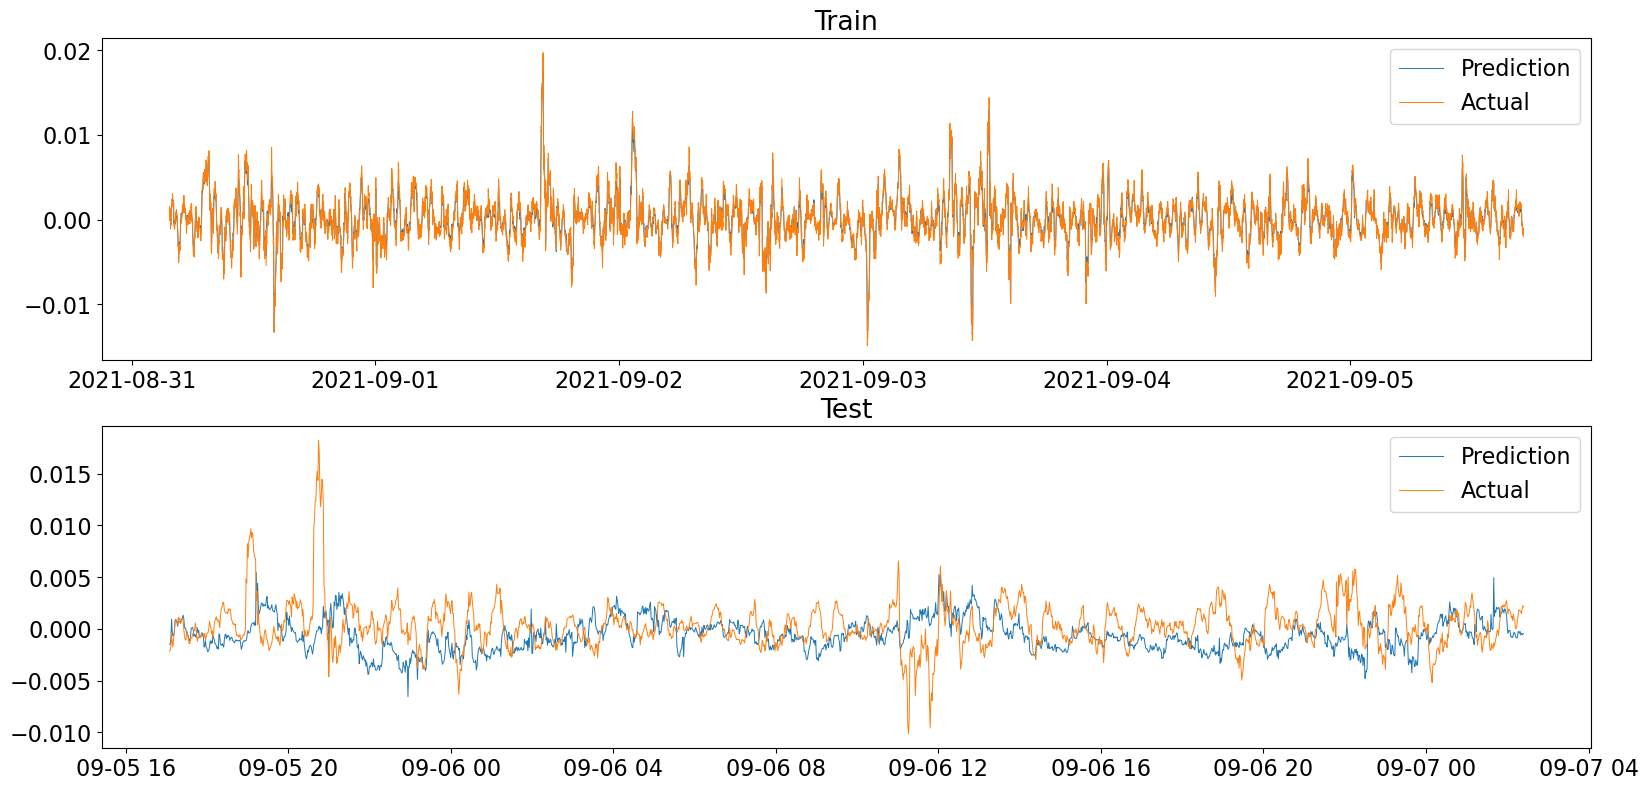

In [45]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series23, label='Prediction')
axes[0].plot(Y23_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series23, label='Prediction')
axes[1].plot(Y23_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

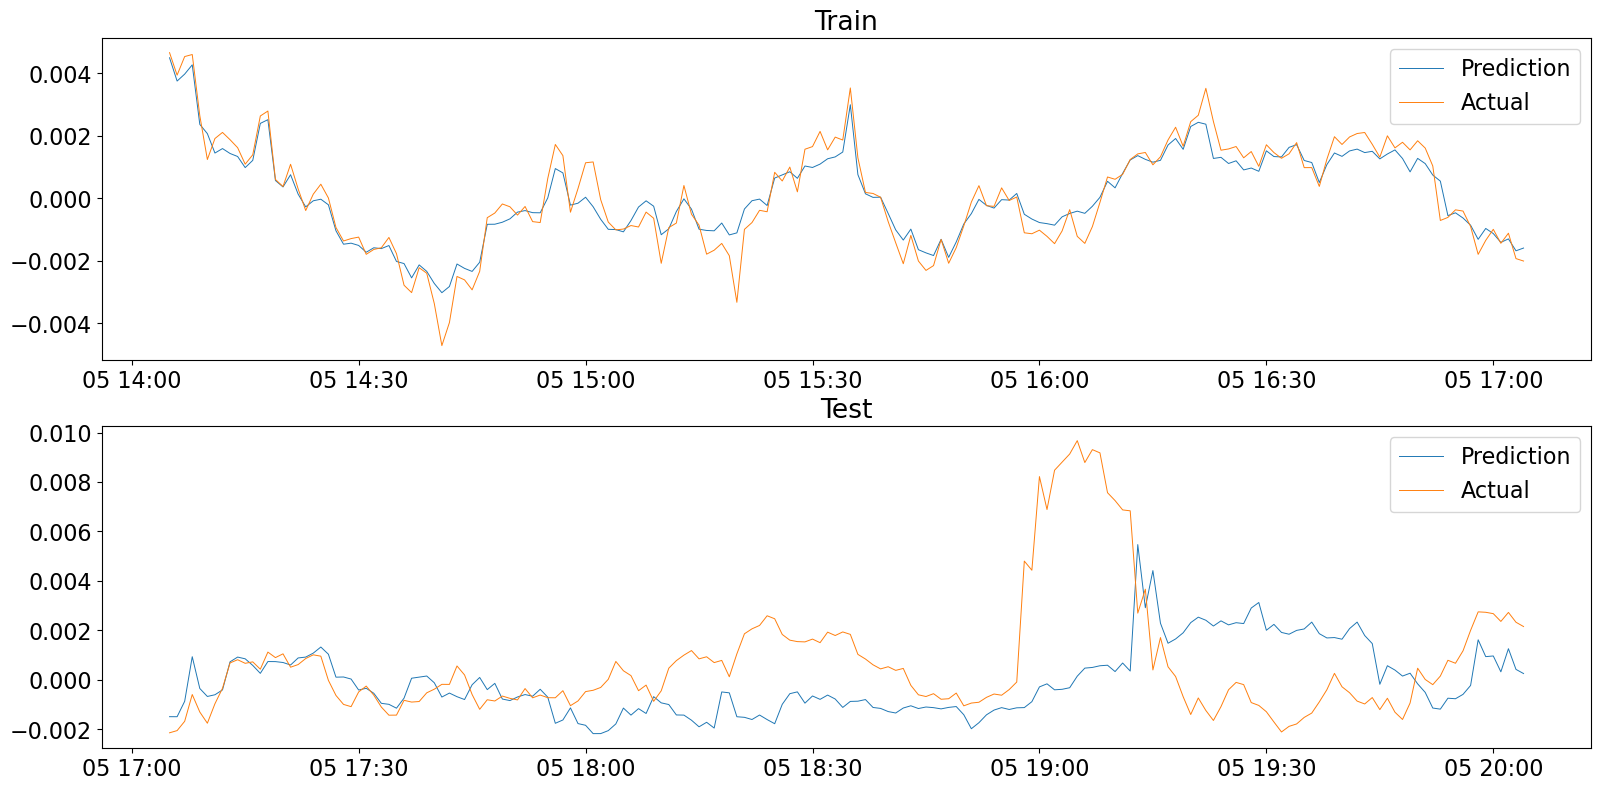

In [46]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series23.tail(180), label='Prediction')
axes[0].plot(Y23_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series23.head(180), label='Prediction')
axes[1].plot(Y23_test.head(180), label='Actual')
axes[1].set_title('Test')
axes[1].legend()

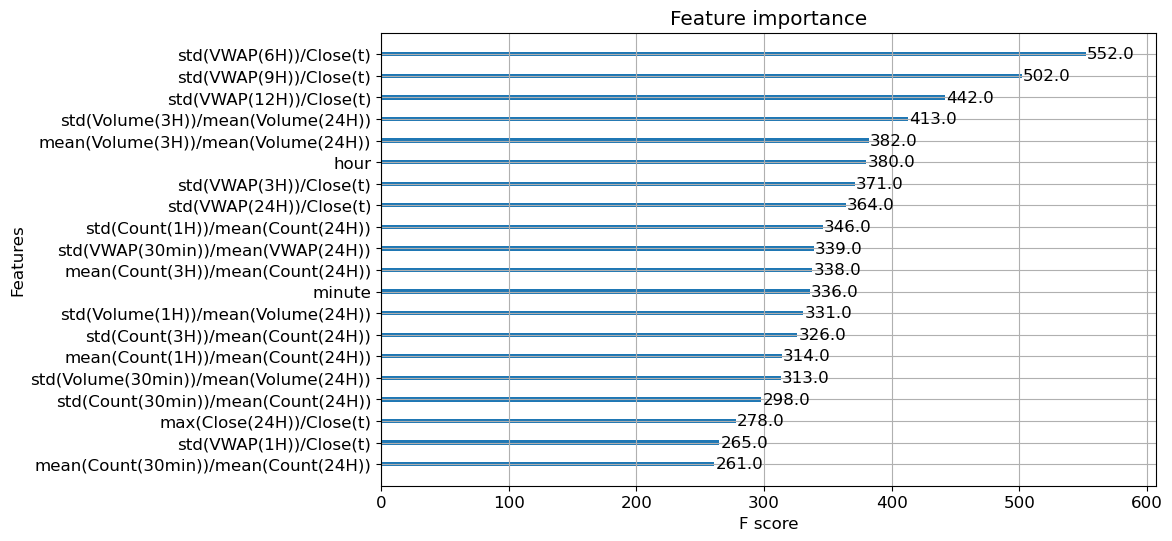

In [47]:
plt.rcParams.update({'figure.dpi': 100, 'font.size':12})

ax = xgboost.plot_importance(model23, max_num_features=20)
fig = ax.figure
fig.set_size_inches(10, 6)

In [174]:
pred_series23 = pd.concat([pred_train_series23, pred_test_series23])
close_series23 = data_raw.Close.loc[data_3.index]
target_series23 = data_3.Target2

In [175]:
table23 = pd.DataFrame({'initial target': target_series23, 'predicted target': pred_series23, 'actual close': close_series23})

In [182]:
table23['mean(Close(1H))']=data_raw.Close.rolling('1H').mean()
table23['Close(t+15)']=(table23['initial target']+1)*table23['mean(Close(1H))']
table23['predicted Close(t+15)']=(table23['predicted target']+1)*table23['mean(Close(1H))']
table23['Close(t+15)']=table23['Close(t+15)'].shift(-15)
table23['predicted Close(t+15)']=table23['predicted Close(t+15)'].shift(-15)

In [183]:
table23.to_csv('close_predictions/table23.csv')

In [184]:
table23 = pd.read_csv('close_predictions/table23.csv')
table23 = table23.reset_index(drop=True)
table23['timestamp'] = pd.to_datetime(table23['timestamp'])
table23 = table23.set_index('timestamp')
table23

,initial target,predicted target,actual close,mean(Close(1H)),Close(t+15),predicted Close(t+15)
timestamp,,,,,,
2021-08-31 03:44:00,0.001518,0.001509,47083.842857,47068.631976,47222.137527,47202.859123
2021-08-31 03:45:00,0.000783,0.001073,47094.154286,47070.155119,47223.644189,47226.060210
2021-08-31 03:46:00,0.000675,0.000893,47101.481429,47071.552572,47218.773198,47215.213331
2021-08-31 03:47:00,-0.000178,0.000656,47116.020000,47073.569453,47257.115586,47232.680713
2021-08-31 03:48:00,0.000532,0.000870,47113.841429,47075.840379,47204.765690,47204.658416
...,...,...,...,...,...,...
2021-09-07 02:20:00,0.001640,-0.000594,52649.095000,52574.348075,NaN,NaN
2021-09-07 02:21:00,0.001475,-0.000420,52651.740000,52575.060853,NaN,NaN
2021-09-07 02:22:00,0.001963,-0.000572,52645.412857,52575.058805,NaN,NaN


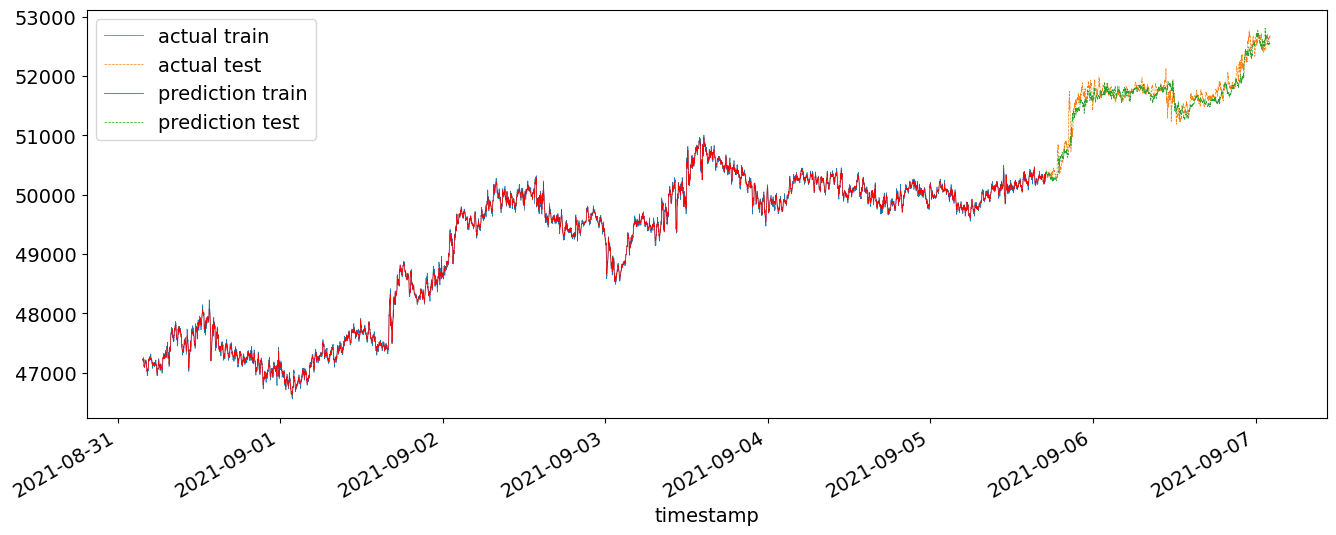

In [203]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 0.5, 'font.size': 14})

table23['Close(t+15)'].loc[Y23_train.index].plot(label='actual train')
table23['Close(t+15)'].loc[Y23_test.index].plot(label='actual test', linestyle='--')
table23['predicted Close(t+15)'].loc[Y23_train.index].plot(label='prediction train', color='r')
table23['predicted Close(t+15)'].loc[Y23_test.index].plot(label='prediction test', linestyle='--')

plt.legend()
plt.show()

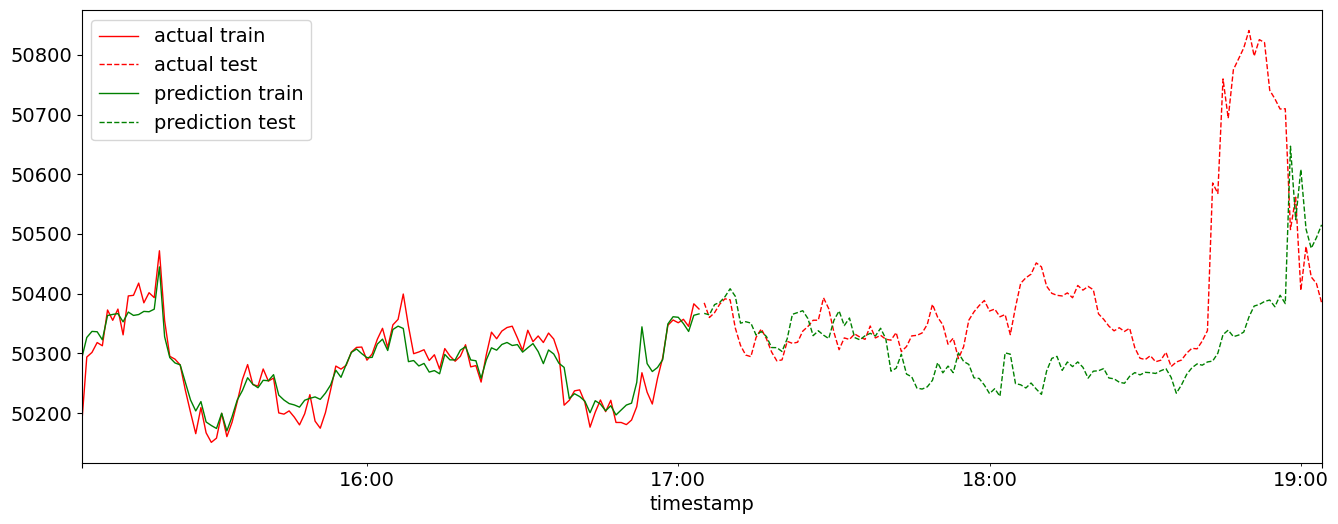

In [190]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 1, 'font.size': 14})

table23['Close(t+15)'].loc[Y23_train.tail(120).index].plot(label='actual train', color='r')
table23['Close(t+15)'].loc[Y23_test.head(120).index].plot(label='actual test', linestyle='--', color='r')
table23['predicted Close(t+15)'].loc[Y23_train.tail(120).index].plot(label='prediction train', color='g')
table23['predicted Close(t+15)'].loc[Y23_test.head(120).index].plot(label='prediction test', linestyle='--', color='g')

plt.legend()
plt.show()

### RandomSearch Y24 BlockingTimeSeriesSplit

In [48]:
model24 = xgboost.XGBRegressor(
    eta=best_eta,
    n_estimators=best_nest,
    reg_lambda=best_lambda,
    alpha=best_alpha,
    eval_metric='rmse',
    booster='gbtree',
    objective='reg:pseudohubererror'
)
model24.fit(X4_train, Y24_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.03, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', ...)

In [49]:
pred_train24 = model24.predict(X4_train)
pred_test24 = model24.predict(X4_test)

pred_train_series24 = pd.Series(pred_train24, index=Y24_train.index)
pred_test_series24 = pd.Series(pred_test24, index=Y24_test.index)

rmse_train24 = math.sqrt(mean_squared_error(Y24_train, pred_train24))
rmse_test24 = math.sqrt(mean_squared_error(Y24_test, pred_test24))

In [50]:
print('train rmse: ', rmse_train24)
print('test rmse: ', rmse_test24)

train rmse:  0.000689889330014107
test rmse:  0.0026267673655192224


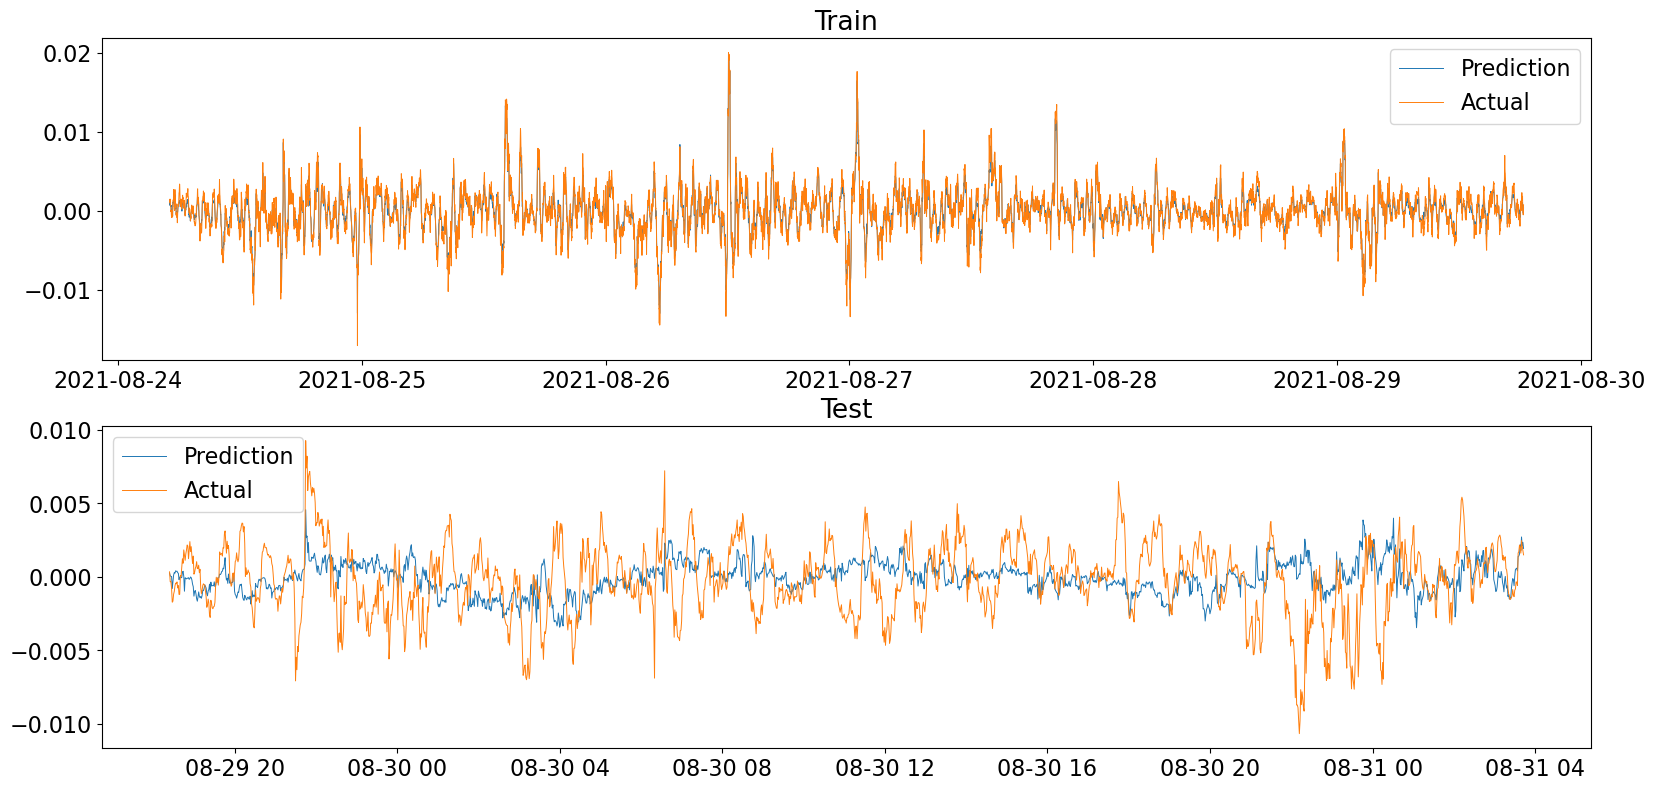

In [51]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series24, label='Prediction')
axes[0].plot(Y24_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series24, label='Prediction')
axes[1].plot(Y24_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

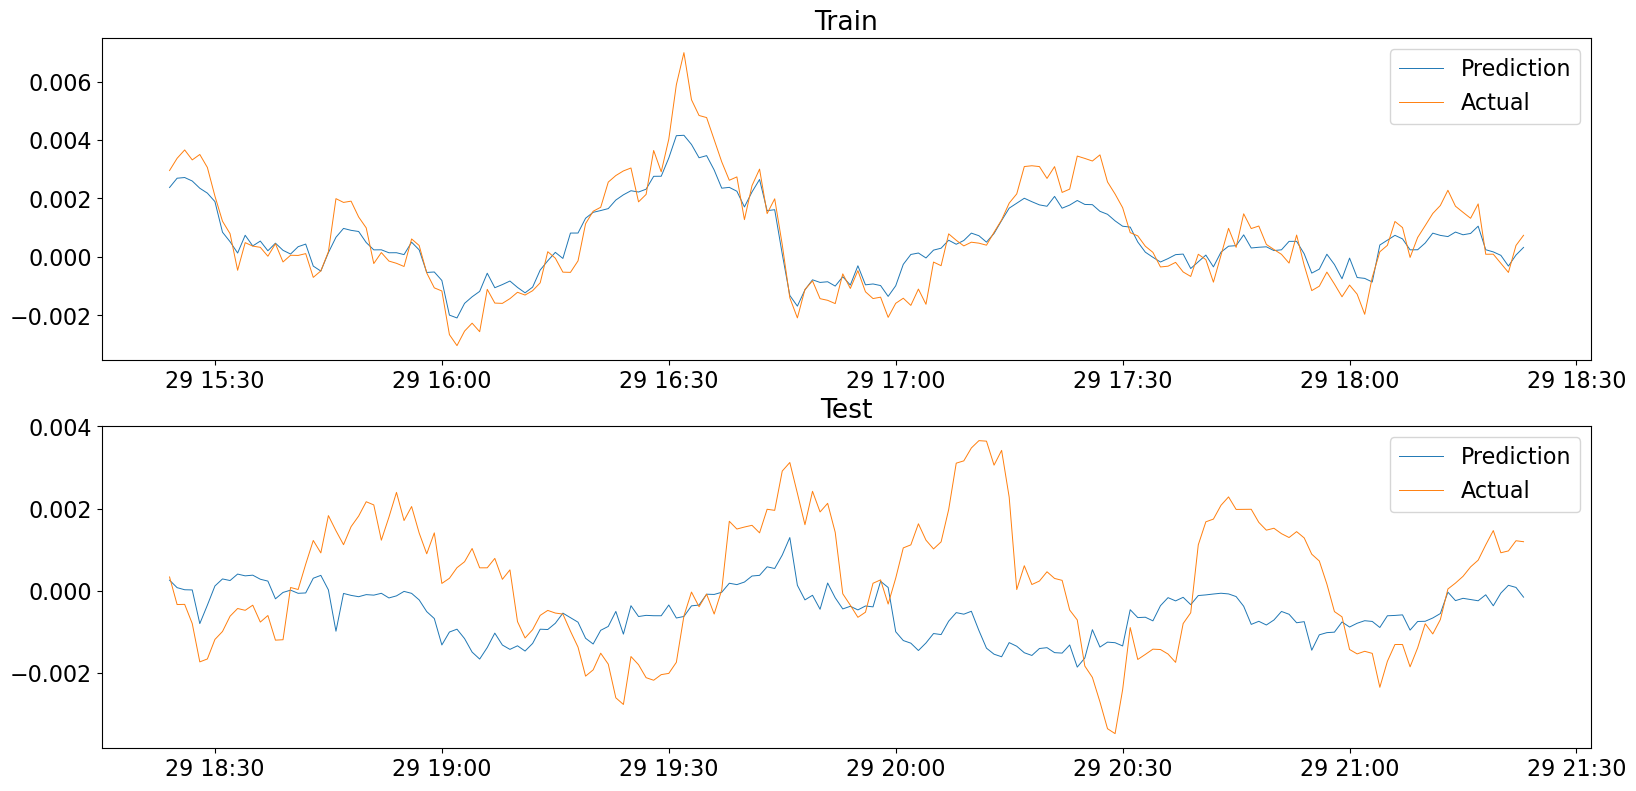

In [52]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series24.tail(180), label='Prediction')
axes[0].plot(Y24_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series24.head(180), label='Prediction')
axes[1].plot(Y24_test.head(180), label='Actual')
axes[1].set_title('Test')
axes[1].legend()

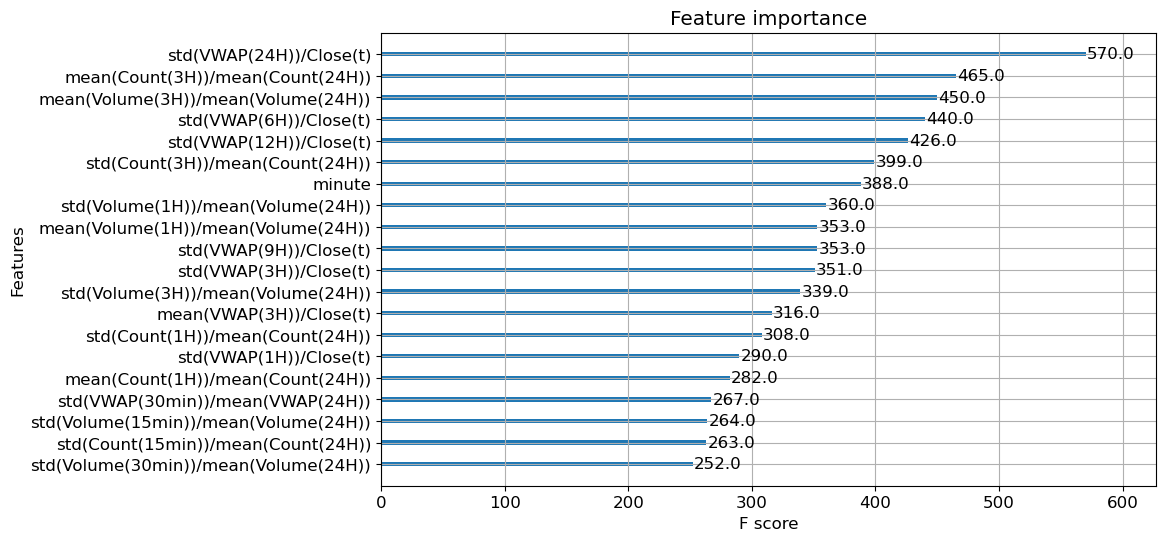

In [55]:
plt.rcParams.update({'figure.dpi': 100, 'font.size':12})

ax = xgboost.plot_importance(model24, max_num_features=20)
fig = ax.figure
fig.set_size_inches(10, 6)

In [182]:
pred_series24 = pd.concat([pred_train_series24, pred_test_series24])
close_series24 = data_raw.Close.loc[data_4.index]
target_series24 = data_4.Target2

In [183]:
table24 = pd.DataFrame({'initial target': target_series24, 'predicted target': pred_series24, 'actual close': close_series24})

In [185]:
table24['mean(Close(1H))']=data_raw.Close.rolling('1H').mean()
table24['Close(t+15)']=(table24['initial target']+1)*table24['mean(Close(1H))']
table24['predicted Close(t+15)']=(table24['predicted target']+1)*table24['mean(Close(1H))']
table24['Close(t+15)']=table24['Close(t+15)'].shift(-15)
table24['predicted Close(t+15)']=table24['predicted Close(t+15)'].shift(-15)

In [186]:
table24.to_csv('close_predictions/table24.csv')

In [187]:
table24 = pd.read_csv('close_predictions/table24.csv')
table24 = table24.reset_index(drop=True)
table24['timestamp'] = pd.to_datetime(table24['timestamp'])
table24 = table24.set_index('timestamp')
table24

,initial target,predicted target,actual close,mean(Close(1H)),Close(t+15),predicted Close(t+15)
timestamp,,,,,,
2021-08-24 05:04:00,0.001286,0.000708,49480.520000,49389.331746,49432.417978,49427.293442
2021-08-24 05:05:00,0.001380,0.001246,49470.482857,49390.247341,49399.223819,49421.612934
2021-08-24 05:06:00,0.001063,0.000803,49476.305714,49391.543579,49401.421683,49442.293825
2021-08-24 05:07:00,0.001465,0.000837,49469.316948,49393.215052,49410.635441,49413.552902
2021-08-24 05:08:00,0.000833,0.000801,49457.814907,49394.675321,49487.745858,49490.499113
...,...,...,...,...,...,...
2021-08-31 03:39:00,0.001610,0.001791,47095.667143,47059.331858,NaN,NaN
2021-08-31 03:40:00,0.002463,0.002711,47076.117143,47061.065858,NaN,NaN
2021-08-31 03:41:00,0.002087,0.002097,47081.205344,47063.180810,NaN,NaN


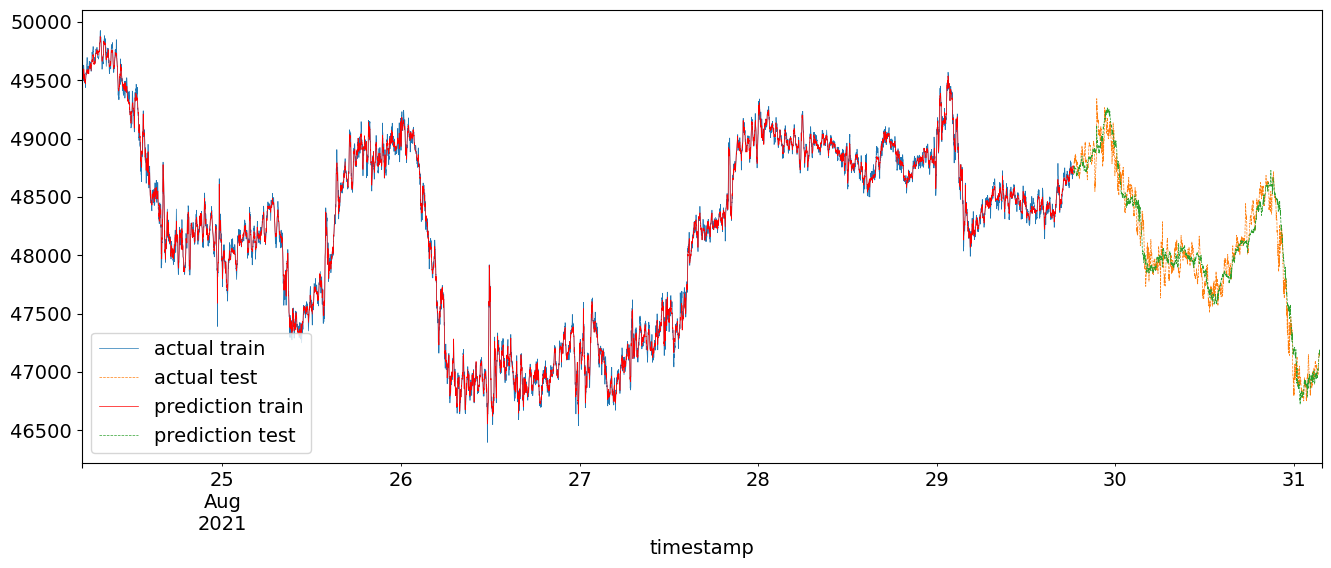

In [204]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 0.5, 'font.size': 14})

table24['Close(t+15)'].loc[Y24_train.index].plot(label='actual train')
table24['Close(t+15)'].loc[Y24_test.index].plot(label='actual test', linestyle='--')
table24['predicted Close(t+15)'].loc[Y24_train.index].plot(label='prediction train', color='r')
table24['predicted Close(t+15)'].loc[Y24_test.index].plot(label='prediction test', linestyle='--')

plt.legend()
plt.show()

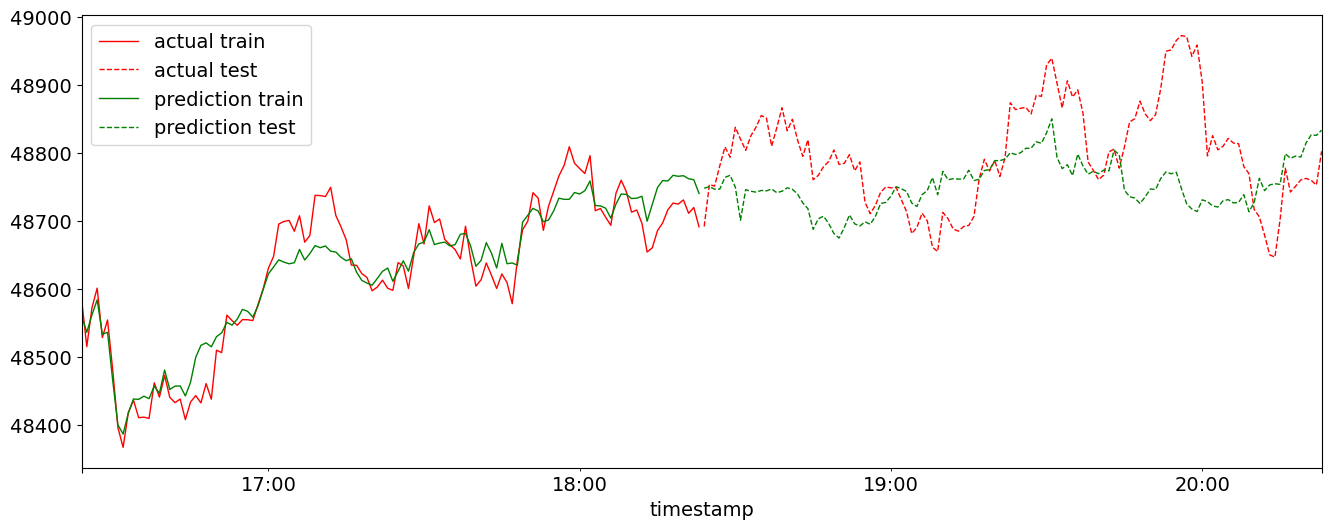

In [191]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth': 1, 'font.size': 14})

table24['Close(t+15)'].loc[Y24_train.tail(120).index].plot(label='actual train', color='r')
table24['Close(t+15)'].loc[Y24_test.head(120).index].plot(label='actual test', linestyle='--', color='r')
table24['predicted Close(t+15)'].loc[Y24_train.tail(120).index].plot(label='prediction train', color='g')
table24['predicted Close(t+15)'].loc[Y24_test.head(120).index].plot(label='prediction test', linestyle='--', color='g')

plt.legend()
plt.show()

### Sample results

In [212]:
sample_comp=pd.DataFrame(data={
    'rmse train': [rmse_train2, rmse_train22, rmse_train23, rmse_train24],
    'rmse test': [rmse_test2, rmse_test22, rmse_test23, rmse_test24]
}, index=['sample 1', 'sample 2', 'sample 3', 'sample 4'])
sample_comp.to_csv('sample_comp.csv')
sample_comp

,rmse train,rmse test
sample 1,0.000539,0.007295
sample 2,0.000787,0.005718
sample 3,0.000595,0.002850
sample 4,0.000690,0.002627
